In [1]:
from keras.preprocessing.sequence import pad_sequences
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import sys

In [1]:
python --version

NameError: name 'python' is not defined

In [3]:
import sys
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [5]:
pip install tensorflow==2.15.0


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [2]:
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np
import tensorflow as tf

In [3]:

import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras

In [4]:
train_label_length = np.load('./wgt/train_label_length.npy')
train_input_length = np.load('./wgt/train_input_length.npy')
training_img = np.load('./wgt/training_img.npy')
train_padded_txt = np.load('./wgt/train_padded_txt.npy')
max_label_len = np.load('./wgt/max_label_len.npy')

In [5]:
print(train_label_length.shape)
print(train_input_length.shape)
print(training_img.shape)
print(train_padded_txt.shape)

(390000,)
(390000,)
(390000, 32, 128, 1)
(390000, 23)


In [12]:
inputs = Input(shape=(32,128,1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(s)
conv_1 = Dropout(0.25)(conv_1)
conv_1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_1)
conv_2= BatchNormalization(axis=-1)(conv_2)
conv_2 = Dropout(0.25)(conv_2)
conv_2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(pool_2)
conv_3= BatchNormalization(axis=-1)(conv_3)
conv_3 = Dropout(0.25)(conv_3)
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
conv_4 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(62+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 lambda_2 (Lambda)           (None, 32, 128, 1)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 128, 16)       160       
                                                                 
 dropout_3 (Dropout)         (None, 32, 128, 16)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 128, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 32)        0         
 g2D)                                                            
                                                           

In [13]:
char_list = string.ascii_letters+string.digits

In [16]:
def display(x):

  # load the saved best model weights
  act_model.load_weights('./models/best_model.hdf5')
  x = cv2.resize(x, (128, 32))
  print(x)
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n') 

[[149 149 149 ... 255 255 255]
 [149 149 149 ... 255 255 255]
 [149 149 149 ... 255 255 255]
 ...
 [154 151 150 ... 255 255 255]
 [146 140 144 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 2s 2s/step


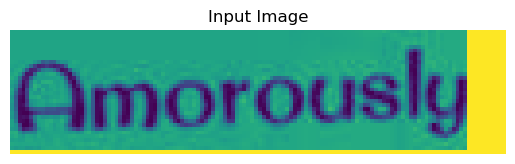

predicted text = Amorously

[[ 25  25  25 ... 255 255 255]
 [ 25  25  25 ... 255 255 255]
 [ 25  25  25 ... 255 255 255]
 ...
 [ 25  26  28 ... 255 255 255]
 [ 23  26  24 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 33ms/step


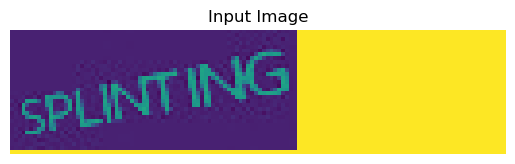

predicted text = SPLINTING

[[223 223 224 ... 255 255 255]
 [225 223 222 ... 255 255 255]
 [222 221 222 ... 255 255 255]
 ...
 [224 225 225 ... 255 255 255]
 [224 224 224 ... 255 255 255]
 [224 224 223 ... 255 255 255]]
1/1 [==============================] - 0s 31ms/step


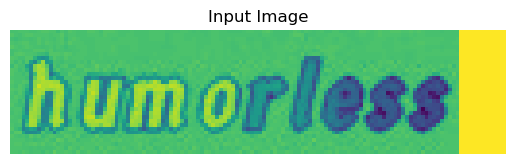

predicted text = humorless

[[133 133 133 ... 255 255 255]
 [133 133 133 ... 255 255 255]
 [133 133 133 ... 255 255 255]
 ...
 [136 136 127 ... 255 255 255]
 [128 126 138 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 32ms/step


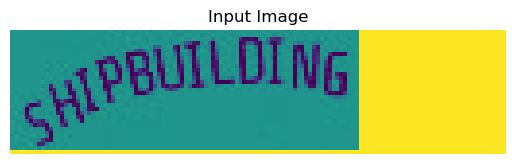

predicted text = SHIPBUILDING

[[178 178 178 ... 255 255 255]
 [178 178 178 ... 255 255 255]
 [178 178 178 ... 255 255 255]
 ...
 [181 177 178 ... 255 255 255]
 [174 175 177 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 35ms/step


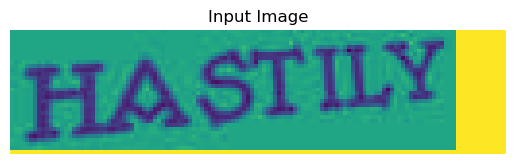

predicted text = HASTILY

[[112 106 111 ... 255 255 255]
 [117 112 111 ... 255 255 255]
 [112 112 118 ... 255 255 255]
 ...
 [104 104 105 ... 255 255 255]
 [103 103 103 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 22ms/step


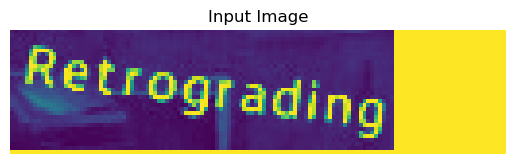

predicted text = Retrograding

[[140 135 131 ... 255 255 255]
 [139 136 134 ... 255 255 255]
 [137 137 137 ... 255 255 255]
 ...
 [137 137 138 ... 255 255 255]
 [137 137 137 ... 255 255 255]
 [136 137 137 ... 255 255 255]]
1/1 [==============================] - 0s 36ms/step


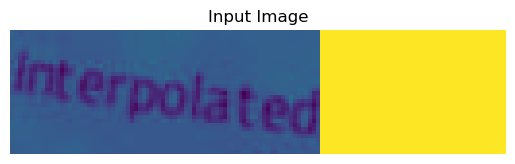

predicted text = interpolated

[[ 27  27  22 ... 255 255 255]
 [ 27  24  27 ... 255 255 255]
 [ 27  24  25 ... 255 255 255]
 ...
 [ 25  24  22 ... 255 255 255]
 [ 22  27  26 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 48ms/step


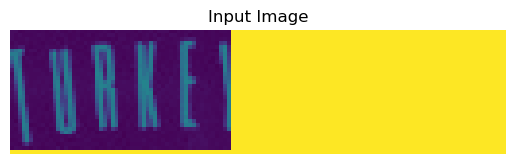

predicted text = lurker



In [17]:
for _ in range(8):
  i = np.random.randint(300000)
#   print(training_img[i])
  display(training_img[i])

<h1>Prediction</h1>

In [18]:
import cv2
import pytesseract
import numpy as np

In [12]:
# it will not predict correct

def display(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the grayscale image
    resized_image = cv2.resize(gray_image, (128, 32))
    plt.imshow(resized_image)
    plt.show()
    
    # Normalize pixel values
    resized_image = resized_image / 255.0
    
    # Add batch dimension
    resized_image = np.expand_dims(resized_image, axis=-1)
    
    # Load the saved best model weights
    act_model.load_weights('./best_model.hdf5')
    
    # Reshape the image to match the input shape expected by the model
    resized_image = np.expand_dims(resized_image, axis=0)
    
    # Make prediction
    prediction = act_model.predict(resized_image)
    
    # Use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                    greedy=True)[0][0])
    
    # Display the input image
#     plt.title('Input Image')
#     plt.imshow(gray_image, cmap='gray')
#     plt.axis('off')
#     plt.show()

    # See the results
    for x in out:
        print("Predicted text = ", end='')
        for p in x:  
            if int(p) != -1:
                print(char_list[int(p)], end='')       
        print('\n')


<h1> Prediction Part</h1>

In [19]:
def displayResults(x):
  li = []
  # load the saved best model weights
  gray_image = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    
    # Resize the grayscale image
  x = cv2.resize(gray_image, (128, 32))
  act_model.load_weights('./models/best_model.hdf5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
#   plt.title('Input Image')
#   plt.imshow(x)
#   plt.axis('off')
#   plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')
              li.append(char_list[int(p)])
      print('\n') 
  return li

In [20]:
def detect_and_crop_text(image_path):
    # Load the image
    image = cv2.imread(image_path)
#     plt.imshow(image)
#     plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     plt.imshow(gray)
    
    # Perform text detection using pytesseract
    custom_config = r'--oem 3 --psm 6'  # OCR configuration
    text_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT, config=custom_config)

    # Crop the regions where text is detected
    cropped_images = []
    for i, text in enumerate(text_data['text']):
        if text.strip():  # Check if the detected text is non-empty
#             print(text)
            x, y, w, h = text_data['left'][i], text_data['top'][i], text_data['width'][i], text_data['height'][i]
            cropped_image = image[y:y+h, x:x+w]
#             plt.imshow(cropped_image)
#             plt.show()
            cropped_images.append(cropped_image)

    return cropped_images

In [21]:
img_file = './images/img5.png'
cropped_images = detect_and_crop_text(img_file)
li = []
for cropped_image in cropped_images:
    li.append(displayResults(cropped_image))

1/1 [==============================] - 0s 31ms/step
predicted text = As

1/1 [==============================] - 0s 34ms/step
predicted text = S

1/1 [==============================] - 0s 24ms/step
predicted text = software

1/1 [==============================] - 0s 36ms/step
predicted text = interface

1/1 [==============================] - 0s 16ms/step
predicted text = for

1/1 [==============================] - 0s 59ms/step
predicted text = graphics

1/1 [==============================] - 0s 31ms/step
predicted text = hardware

1/1 [==============================] - 0s 30ms/step
predicted text = Opengls

1/1 [==============================] - 0s 38ms/step
predicted text = moain

1/1 [==============================] - 0s 35ms/step
predicted text = purpose

1/1 [==============================] - 0s 34ms/step
predicted text = Des

1/1 [==============================] - 0s 30ms/step
predicted text = i

1/1 [==============================] - 0s 42ms/step
predicted text = render

1/1 [====

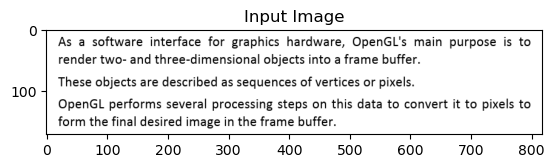

Predicted text is : As S software interface for graphics hardware Opengls moain purpose Des i render CMO an Ihreeatlimensiona objects into Cy frame buffer These objects Sr described S sequences CT vertices Or pixels Opengl performs severa orocessing stepos O tois cat i convert Oa i pixels i form to final desired Image D to frame buffer 

In [22]:
image = cv2.imread(img_file)
plt.title("Input Image")
plt.imshow(image)
# plt.axis('off')
plt.show()




print("Predicted text is :",end=' ')
for i in li:
    print(''.join(i),end = ' ')